In [1]:
# general imports needed by functions
import errno    
import os

# import python scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import needed keras objects into current namespace
from keras import layers
from keras import models
from keras import optimizers


Using TensorFlow backend.


In [2]:
# set plotting visual style and parameters for all plotted figures
%matplotlib inline
sns.set_style('darkgrid') # use seaborn style to improve visual presentation
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12.0 , 8.0)

In [3]:
import tensorflow as tf

print("is gpu available? ", tf.test.is_gpu_available())
print("")

# check which devices tensorflow has recognized and is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

is gup available?  False

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9868249592297746104
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16859819057464299092
physical_device_desc: "device: XLA_CPU device"
]


# 6. Deep Learning for Text and Sequences

We will use *recurrent neural networks* and *1D convnets* for:

- Document classification and timeseries classification.
- Timeseries comparisons (estimate closeness sof documents or stockcs)
- Sequence-to-sequence learning (e.g. natural language translation)
- Sentiment analysis (postiive or negative movie reviews)
- Timeseries forecasting (predict future weather given timeseries of past weather).

## 6.1 Working with text data

Deep learning for NLP is pattern recognition applied to words, sentences and paragraphs, in much the same way
that computer vision is pattern recognition applied to pixels.

Like all machine learning and NN models, deep-learning need numeric tensors, they can't work with raw
text as input (as we have seen).  *Vectorizing* text is the process of transforming text into numeric tensors.
This can be done in multiple ways:
- Segment text into words, and transform each word into a vector.
- Segment text into characters, and transfrom each character into a vector.
- Extract n-grams of words or characters, and transform each n-gram into a vector.

Where *n-grams* are overlapping groups of multiple consecutive words or characters.

Generically, the different units we encode text into (words, characters, or n-grams) can be referred to
as *tokens*, and breaking text into such tokens is called *tokenization*.  The first step in parsing a
computer language in order to compile or interpret it is to tokenize the input, and likewise, the first step in
a NLP task is to tokenize the text before processing can begin.

All text-vectorization consists of applying some tokenization scheme then associating a resulting
numeric vector with the generated tokens.  These vectors, packed into sequence tensors, are fed
into deep neural networks.

Two major approaches to associating a numeric vector with tokens:
- *one-hot encoding*
- *token embedding* (typically for words known as *word embedding*.


This section looks at these two techniques in more detail (we have seen examples of one-hot encoding
in previous sections.  

### 6.1.1 One-hot encoding of words and characters

One-hot encoding is the most common and most basic way to turn character tokens into a vector.
It consists of associating a unique integer index with every word, and then turning this integer
index $i$ into a binary vector of size $N$ (the size of the vocabulary); the vector is all zeros
except for the $i$th entry, which is 1.

One-hot encoding can be done at the character level.

The toy example for word-level one-hot encoding (Listing 6.1)

In [4]:
# example samples.  In this example, each sample is a single sentence
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# build an index of all tokens in the data
token_index = {}
for sample in samples:
    # example of tokenizing by word.  In a real problem, we would (usually)
    # strip punctuation and special characters
    for word in sample.split():
        if word not in token_index:
            # an arbitrary unique index assigned for each word
            token_index[word] = len(token_index) + 1

# we only consider the first max_length words in each sample
max_length = 10

# where we store the results, tensor one entry for each sample
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

# vectorize the samples
for i, sample in enumerate(samples):
    # look at each word in the sample
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1 # one-hot encoding
        

# show the resulting representation
print(results.shape)
print(token_index)
print(results[0, 0, :]) # first word of first sample, The is index 1, one-hot encoded

(2, 10, 11)
{'The': 1, 'cat': 2, 'sat': 3, 'on': 4, 'the': 5, 'mat.': 6, 'dog': 7, 'ate': 8, 'my': 9, 'homework.': 10}
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The toy example for character-level one-hot encoding

In [5]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# all printable ASCII characters
characters = string.printable
# build index of the characters
# BUG: textbook reverses key/value of the token_index, we correct here
token_index = dict(zip(characters, range(1, len(characters) + 1)))


# vectorize the samples
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
print(results[0, 0, :]) # first character of first sample
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        print(i, j, index, character)
        results[i, j, index] = 1
        
# show the resulting representation
print(results.shape)
print(token_index)
print(results[0, 0, :]) # first character of first sample

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
0 0 56 T
0 1 18 h
0 2 15 e
0 3 95  
0 4 13 c
0 5 11 a
0 6 30 t
0 7 95  
0 8 29 s
0 9 11 a
0 10 30 t
0 11 95  
0 12 25 o
0 13 24 n
0 14 95  
0 15 30 t
0 16 18 h
0 17 15 e
0 18 95  
0 19 23 m
0 20 11 a
0 21 30 t
0 22 76 .
1 0 56 T
1 1 18 h
1 2 15 e
1 3 95  
1 4 14 d
1 5 25 o
1 6 17 g
1 7 95  
1 8 11 a
1 9 30 t
1 10 15 e
1 11 95  
1 12 23 m
1 13 35 y
1 14 95  
1 15 18 h
1 16 25 o
1 17 23 m
1 18 15 e
1 19 33 w
1 20 25 o
1 21 28 r
1 22 21 k
1 23 76 .
(2, 50, 101)
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q

Kerhas has built-in library functions for one-hot encoding of text at word or character level, starting from
raw text data.  They take care of stripping special characters and only using N most common words in the
dataset.

In [6]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# creates tokenizer configured to only use 1000 most common words
tokenizer = Tokenizer(num_words=1000)

# builds the word index
tokenizer.fit_on_texts(samples)

# turns strings into lists of integer indexes
sequences = tokenizer.texts_to_sequences(samples)

# other vectorizations are supported, but texts_to_matrix does same as we did above by hand
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# can be used to recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# show the results
print(word_index)
print(one_hot_results.shape)
print(one_hot_results[0,:])

Found 9 unique tokens.
{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
(2, 1000)
[0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

A variant is *one-hot hasing*.  If number of unique tokens is very large, hash words into vectors of fixed size.
It is a hash, so *hash collisions* may occur and 2to different words end up with same hash.

In [7]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # hashes the word into a random integer index between 0 and 1000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1
        
print(results.shape)
print(results[0, 0, :])
print(abs(hash('The')) % dimensionality)

(2, 10, 1000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

### 6.1.2 Using word embeddings

Another populaer method is using dense *word vectors* also called *word embeddings*.

One-hot encodings are binary, sparse (mostly zeros) and very high-dimensional.

Word embeddings are low-dimensional floating-point vectors (that is dense vectors).
Word embeddings are learned from data.  It is common to see word embeddings that
are 256, 512 or 1024 dimensional when dealing with very large vocaularies.  

Two ways to obtain word embeddings:
- Learn word embeddings jointly with the main task (initially word vectors are random, and they are learned
  in the same way you learn weights).
- Load embeddings that were precomputed using a different machine-learning task.  These are
  *pretrained word embeddings*.
  
**Learning Word Embeddings with the Embedding Layer**

It is reasonable to *learn* a new embedding space with every new NLP task.  This can be done using
backpropagation, and Keras has special layers specifically for training a word embedding.  In this
case it becomes about learning the weights of this layer, the `Embedding` layer.

In [8]:
from keras.layers import Embedding

# 1000 is number of possible tokens, and 64 is the embedding dimensionality that
# willbe learned
embedding_layer = Embedding(1000, 64)

The `Embedding` layer that is learned is best understood as a dictionary that maps integer
indices (which stand for specific words) to dense vectors (64 dimensional real-valued number vectors
in this case).  It is effectively a dictionary lookup.  However, as discussed, the resulting embeddings,
once learned, have semantic meanings in the geometrical space that relate words to similar words.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`
where each entery is a sequence of integers.  It can embed sequences of variable lengths:
for instance, you could feed into the `Embedding` layer in the previous example batches with shapes
`(32, 10)` (batch of 32 wequences of length 10).  All sequences must have same length, so
will need to padd with zeros if too short or truncate if too long.

The `Embedding` layer returns a 3D floating-point tensor of shape
`(samples, sequence_length, embedding_dimensionality)`.
Such a 3D tensor can then be processed by an RNN layer or 1D convolution.

Iniitally the weights of such a layer are random.  During training, these vectors are adjusted,
structuring the space into something that can be exploited by the downstream task.  Once fully
trained, the embedding space will show a lot of structure.

Using the IMDB movie-review sentiment-prediction task.  We prepare the data.  We restrict to the top
10,000 most common words, and cut off the reviews after only 20 words.  This example will learn
an 8-dimensional embedding for each of the 10,000 words, turn the input integer sequence (2D integer
tensor) into the embedded sequence (3D float tensor), flatten the tensor to 2D, and train a single
`Dense` layer on top for classification (remember we are doing a binary classification of good vs. bad
review sentiment).


In [13]:
# the following is a bug in keras introduced because np has stopped allowing pickle loads by default
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [14]:
from keras.datasets import imdb
from keras import preprocessing

# number of words to considre as features
max_features = 10000
# cuts off text aftre this number of words
maxlen = 20

# loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(
     num_words=max_features)

# turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)
print(x_train[0,:])

(25000, 20)
(25000, 20)
[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32
   15   16 5345   19  178   32]


In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# specifies maximum input length, after the embedding layer, activation have shape (samples, maxlen, 8)
model.add(Embedding(max_features, 8, input_length=maxlen))

#flattens the 3D tensor of the embedding into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# add the classifier on top, use a sigmoid for a binary classifier
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)




Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 3s 128us/step - loss: 0.6760 - acc: 0.6049 - val_loss: 0.6402 - val_acc: 0.6784
Epoch 2/10
20000/20000 [==============================] - 2s 88us/step - loss: 0.5664 - acc: 0.7423 - val_loss: 0.5476 - val_acc: 0.7192
Epoch 3/10
20000/20000 [==============================] - 2s 95us/step - loss: 0.4759 - acc: 0.7803 - val_loss: 0.5120 - val_acc: 0.7388
Epoch 4/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.4269 - acc: 0.8076 - val_loss: 0.5013 - val_acc: 0.7446
Epoch 5/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.3935 - acc: 0.8256 - val_loss: 0.4985 - val_acc: 0.7536
Epoch 6/10
20000/20000 [==============================] - 2s 107us/step - loss: 0.3672 - acc: 0.8396 - val_loss: 0.5017 - val_acc: 0.7526
Epoch 7/10
20000/20000 [==============================] - 2s 97us/step - loss: 0.3438 - acc: 0.8532 - val_loss: 0.5055 

You should get a validation accuracy of ~76%, which is pretty good considering we are only looking at first 20 words
of each review.

This architecutre leads to a model that treats each word in the input sequence separately (without considering
ordering or inter-word relationships).  It will be much better to add recurrent layers or 1D convolutions on top
of the embedding to learn features that take into account word sequences and orderings.

**Using Pretrained Word Embeddings**

Similar to using pre-trained convolutions for an image processing task, we can use embeddings used from
a previous large NLP task.

There are various precomputed databases of word embeddings that can be used in Keras. Word2vec is one
well known example.  Another is Global Vectors for Word Representation (GloVe).

This example shows using GlOve embeddings in a Keras model.

### 6.1.3 Putting it all together: from raw text to word embeddings

You'll use a similar model to before, embedding sentences in sequences of vectors, flattening them, and training
a `Dense` layer on top.  But here we used pretrained word embeddings, and instead of using pretokenized
IMDB data pacakged in Keras, you'll need to start from scratch by downloading the original data.

**Downloading the IMDB Data as Raw Text**

Download the raw IMDB dta from http://mng.bz/0tIo

Uncompress it.

In [18]:
import os

imdb_dir = 'data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**Tokenizing the Data**

Let's vectorize the text and prepare a training and validation split.

Because pretrained word embeddings are meant to be particularly useful on problems where little
training data is available, we will use only first 200 samples for training.

## 6.2 Understanding recurrent neural networks

All networks so far have been strictly *feedforward networks*.  Feedforward networks have no memory.  Each input shown
is processed independently from others, with no state kept in between inputs.  In order to process sequences
with such a network, you have to present entire sequence all in 1 input.

A *recurrent neural network* (RNN) keeps a state: it processes sequences by iterating through sequence elements
and maintaining a *state* containing information relative to what it has seen so far.  It is a type of NN that has 
an internal loop.

To make notions of *loop* and *state* clear, we have a small toy example using `Numpy` only for the
implementation.  This RNN takes as input a sequence of vectors, which are encoded as a tensor
of size `(timesteps, input_features)`.  It loops over timesteps and, at each timestep,
it considers its current state at `t`.  We then set state for the next input to the previous output.  
For the first timestep, the previous output is not defined, so we initialize the state as all zeros
called *initial state*.

```python
# Pseudocode RNN

# The state at t
state_t = 0

# iterates over sequence of elements
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    # The prevous output becomes the state for the next iteration
    state_t = output_t
```

You can even flesh out the function `f`: the transformation of the input and state into
an output will be parameterized by two matrices, `W` and `U`, and a bias vector.  It is
similar to the transformation operation operated by a densely connected layer.

```python
# More detailed pseudocode for the RNN

# The state at t
state_t = 0

# iterates over sequence of elements
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    # The previous output becomes the state for the next iteration
    state_t = output_t
```

To make absolutely unambiguous, let's write a naive `Numpy` implementation of the forward
pass of the simple RNN.

In [19]:
# number of timesteps in the input sequence
timesteps = 100

# dimensionality of the input feature space
input_features = 32

# dimensionality of the output feature space
output_features = 64

# input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))

# initial state: an all-zero vector
state_t = np.zeros((output_features,))

# create random weight matrices, these would be trained by gradient descent
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

# holds the history of the outputs
successive_outputs = []

# input_t is a vector of shape (input_features,)
for input_t in inputs:
    # combines the input with the current state (the previous output) to obtain the current output
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    # stores this output in a list
    successive_outputs.append(output_t)
    
    # updates the state of the network for the next timestep
    state_t = output_t
    
# the final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0).reshape((timesteps, output_features))


print(final_output_sequence.shape)

(100, 64)


In [20]:
print(len(successive_outputs))
print(successive_outputs[0].shape)
print(successive_outputs[0])
print(final_output_sequence[0,:])
print(np.allclose(successive_outputs[0], final_output_sequence[0,:]))

100
(64,)
[0.99999999 0.99999994 0.99999998 0.99999324 0.99999989 0.99999998
 0.99999929 1.         0.99999981 0.99999996 0.99999999 0.99999991
 1.         0.99999998 0.99999988 0.99999977 0.99999998 0.99999994
 0.99999995 1.         0.99999959 0.99999999 0.99999617 0.99999993
 0.99999986 1.         0.99999998 0.99999994 0.99999819 1.
 0.99999985 0.99999999 0.99999885 1.         0.99999998 0.99999894
 1.         0.99999996 1.         1.         1.         1.
 0.99999971 0.9999967  0.9999962  0.99999996 0.99999999 0.99999998
 0.99999935 0.99999997 0.9999998  1.         0.9999994  0.99999999
 0.99999989 0.99994312 0.99999998 0.99999981 0.99999995 0.99999996
 0.99999995 1.         0.99999995 0.99999987]
[0.99999999 0.99999994 0.99999998 0.99999324 0.99999989 0.99999998
 0.99999929 1.         0.99999981 0.99999996 0.99999999 0.99999991
 1.         0.99999998 0.99999988 0.99999977 0.99999998 0.99999994
 0.99999995 1.         0.99999959 0.99999999 0.99999617 0.99999993
 0.99999986 1.        

RNN is a for loop that reuses quantities computed during previous iteration of loop.

RNNs are characterized by their step function, which in the previous code was

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

### 6.2.1 A recurrent layer in Keras

The `SimpleRNN` layer in Keras corresponds to the previous example.  One minor difference: `SimpleRNN`
processes batches of sequences (like all other Keras layers), not a single sequence as in the previous
example.  This means it takes inputs of shape `(batch_size, timesteps, input_features)`.

`SimpleRNN` can be run in 2 different modes: it can return either the full sequence of successive
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, input_features)`) or 
only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`).
These two modes are controlled by the `return_sequences` constructor argument.

If we don't specify, the default is to return only the last output

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

In [22]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence by specifying the `return_sequences` constructor
parameter:

In [23]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Notice the (slight) difference in the returned shape from the RNN layer in the second example.  

It is sometimes useful to stack several recurrent layers one after the other in order to increase the
representational power of a network.  In such a setup, you have to get all of the intermediate layers
to return full sequence of outputs:

In [24]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
# Last layer only returns the last output
model.add(SimpleRNN(32))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model on the IMDB movie-review-classification problem.  First we preprocess
the data.

In [25]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# number of words to consider as features
max_features = 10000
# cuts off text after this many words
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer.

In [26]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.6314 - acc: 0.6244 - val_loss: 0.5134 - val_acc: 0.7598
Epoch 2/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.4025 - acc: 0.8284 - val_loss: 0.4737 - val_acc: 0.7752
Epoch 3/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.3084 - acc: 0.8775 - val_loss: 0.3825 - val_acc: 0.8310
Epoch 4/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.2362 - acc: 0.9088 - val_loss: 0.3608 - val_acc: 0.8486
Epoch 5/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.1830 - acc: 0.9305 - val_loss: 0.4172 - val_acc: 0.8576
Epoch 6/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.1382 - acc: 0.9510 - val_loss: 0.4207 - val_acc: 0.8452
Epoch 7/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.0929 - acc: 0.9686 - val_loss: 0.6776 - val_acc:

Now, lets display the training and validation loss and accuracy.

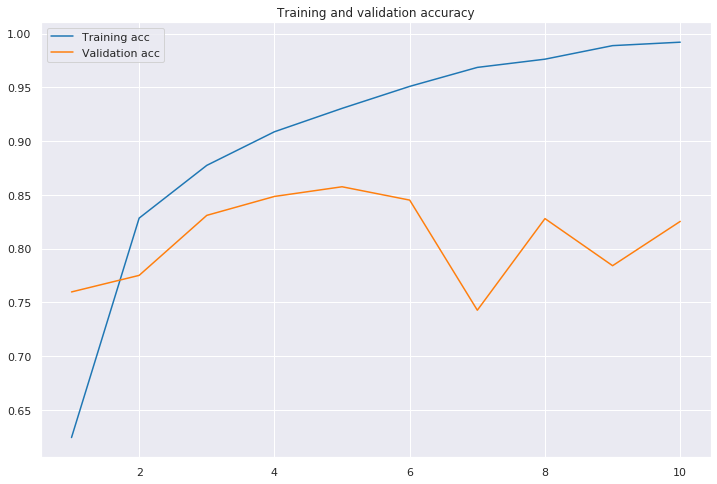

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

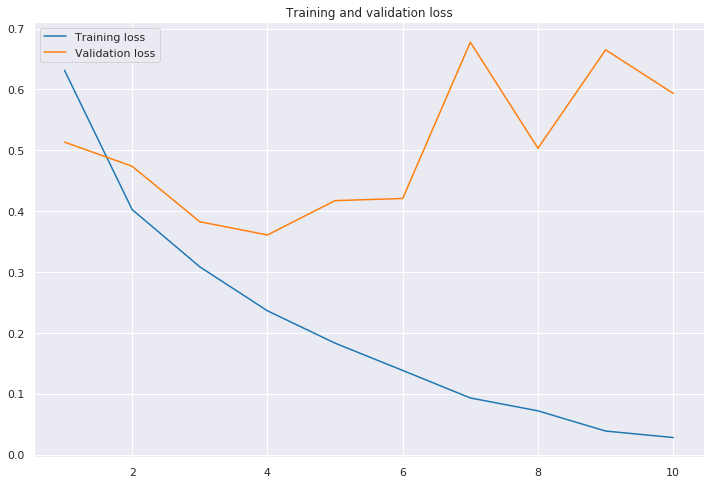

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

As a reminder, in chapter 3 we achieved 88% using a `Dense` network.  Unfortunately this small
recurrent network doesn't perform well compared to this.  The network is overfitting, so it could be improved.

Part of the problem is that we only consider the first 500 words of each review, rather than the
full sequences.  But the bigger problems is that `SimpleRNN` are simply not goot at processing too long
of a sequence, such as written text.  We need other types of recurrent layers which perform
much better on long sequences.

# 6.2.2 Understanding the LSTM and GRU layers

There are 2 other recurrent layers available in Keras: `LSTM` and `GRU`.  `SimpleRNN` is too simple so in
practice we need to use one of these other types of RNN.

`SimpleRNN` suffers from *vanishing gradient problem*.  This effect can also be a problem for deep neural
networks.  It comes about because the information passed back through the gradiants via backpropagation
becomes a weaker signal the further back  you have to transmit it.  In effect, the itteration of the
`SimpleRNN` through time means that the vanishing gradient problem is especially accute.  The
`LSTM` and `GRU` recurrent layers were designed to solve this problem.

Long Short-Term Memory (LSTM) is a variant of the `SimpleRNN`.  It adds a way to carry information
across many timesteps.  It saves (gradient) information for later, thus preventing older signals from
vanishing during processing (espeically for long time sequences).

LSTM is complex, though no more complicated than the `SimpleRNN`. Feedforward computation.  We still have a `U`,
`W` and `b` matrix to compute the output.  But we have an additional bit of
carry information.  The carry information is computed from 3 separate, but same type of matrix
multiplicaiton and addition functions.  This bit of carry information is also considered and added to
the output function. that is computed.

The carry signal is composed of 3 components, labeled `i`, `f` and `k`.  You can interpret these as
a way of forgetting `f` irrelevant information in the carray dataflow, while `i` and `k` provide
information about the present, updating the carry track with new information.  

But in short, just keep in mind what the `LSTM` cell is meant to do: allow past information to be
reinjected at a later time, thus fighting the vanishing-gradient problem.

# 6.2.3 A concrete LSTM example in Keras

Here we use a `LSTM` layer to see how it improves the recurrent network on the IMDB dataset.

In [30]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

This time, we should achieve up to 89% validation accuracy.  This should be better than the `SimpleRNN`
performance, and a bit better than the simple feedforward model from chapter 3 as well.  And again
recall we are still only looking at first 500 words (500 timesteps in the recurrent formulation), whereas
in chapter 3 we were using the full text for all reviews.

But the result isn't significally better, especially considering the much greater computational machinery
now present in the `LSTM`.  Again we may be able to increase performance a bit by tuning the hyper-parameters.
But, as argued in textbook, we probably can't improve much over just simply looking at which words are used
and their frequency.  Thus the simpler model for this simple binary classification task may be difficult to improve
upon using more complex recurrent networks.  

But there are far more difficult natural-language processing problems where LSTM and GRU will make a much
greater difference.

# 6.2.4

- A RNN is a recurrent neural network, you can think of it as implementing a loop that processes a sequence of
  input, and feeds the state (output) from previous timestep into calculation of the next output state.
- LSTM adds in mechanisms to address the vanishing gradients problem, which is especially problematic for recurrent
  neural networks.
- Embedding layers are an alternative to simple one-hot or bag-of-word encodings, that are especially powerful
  for more complex NLP tasks.